Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/step - accuracy: 0.4129 - loss: 1.4490 - val_accuracy: 0.6200 - val_loss: 0.8281
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.5925 - loss: 0.9291 - val_accuracy: 0.7200 - val_loss: 0.7163
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.6731 - loss: 0.7207 - val_accuracy: 0.8000 - val_loss: 0.5636
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.7415 - loss: 0.6041 - val_accuracy: 0.8000 - val_loss: 0.5709
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.8006 - loss: 0.5090 - val_accuracy: 0.8400 - val_loss: 0.4963
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.8175 - loss: 0.4699 - val_accuracy: 0.8800 - val_loss: 0.4324
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.8130 - loss: 0.4452 - val_accuracy: 0.8400 - val_loss: 0.4782
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.8631 - loss: 0.3754 - val_accuracy: 0.8800 - val_loss:

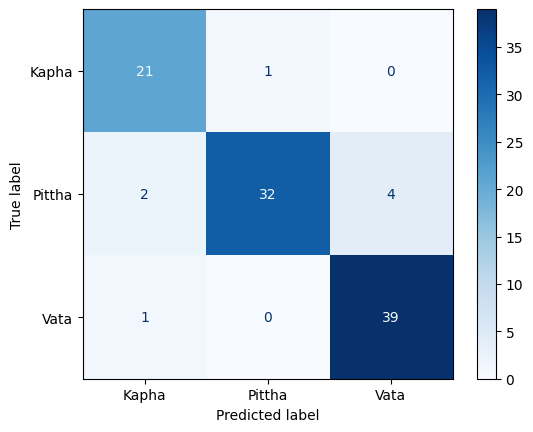

Accuracy: 92.00%


In [1]:
import os
import cv2
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Directories for each class
kapha_dir = r'C:\Users\kaush\Downloads\eyes dataset\train\kapha'
pittha_dir = r'C:\Users\kaush\Downloads\eyes dataset\train\pittha'
vata_dir = r'C:\Users\kaush\Downloads\eyes dataset\train\vata'

# Load and preprocess images
def load_images_from_folder(folder, label):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.resize(img, (224, 224))  # Resize to 224x224
            images.append((img, label))  # Append image and its label as tuple
    return images

# Load images
kapha_images = load_images_from_folder(kapha_dir, 0)  
pittha_images = load_images_from_folder(pittha_dir, 1) 
vata_images = load_images_from_folder(vata_dir, 2)

# Data Augmentation
def augment_images(images, label):
    augmented_images = []
    for img, _ in images:
        h, w = img.shape[:2]
        
        # Random cropping
        x_start = random.randint(0, int(0.1 * w))
        y_start = random.randint(0, int(0.1 * h))
        cropped_img = img[y_start:y_start + h - 20, x_start:x_start + w - 20]
        cropped_img = cv2.resize(cropped_img, (w, h))
        augmented_images.append((cropped_img, label))
        
        # Scaling
        scaled_img = cv2.resize(img, None, fx=1.2, fy=1.2, interpolation=cv2.INTER_LINEAR)
        scaled_img = cv2.resize(scaled_img, (w, h))
        augmented_images.append((scaled_img, label))
        
        # Random perspective transformation
        pts1 = np.float32([[0, 0], [w-1, 0], [0, h-1], [w-1, h-1]])
        pts2 = np.float32([
            [random.randint(0, w//4), random.randint(0, h//4)],
            [random.randint(w-1-w//4, w-1), random.randint(0, h//4)],
            [random.randint(0, w//4), random.randint(h-1-h//4, h-1)],
            [random.randint(w-1-w//4, w-1), random.randint(h-1-h//4, h-1)]
        ])
        matrix = cv2.getPerspectiveTransform(pts1, pts2)
        perspective_img = cv2.warpPerspective(img, matrix, (w, h))
        augmented_images.append((perspective_img, label))

    return augmented_images

# Apply augmentation
augmented_kapha_images = augment_images(kapha_images, 0)
augmented_pittha_images = augment_images(pittha_images, 1)
augmented_vata_images = augment_images(vata_images, 2)

# Combine original and augmented images
data = kapha_images + pittha_images + vata_images + augmented_kapha_images + augmented_pittha_images + augmented_vata_images
X, y = zip(*data)  # Unzip the list of tuples into separate lists
X = np.array(X)
y = np.array(y)

# Normalize images
X = X / 255.0  # Scale pixel values to [0, 1]

# Reshape X to 224x224x3 for DenseNet121 input
X_reshaped = np.repeat(X, 3, axis=-1) if X.shape[-1] == 1 else X

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)

# Build the DenseNet121 model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
base_model.trainable = False

# Add custom classification layers on top of DenseNet121
x = GlobalAveragePooling2D()(base_model.output)  # Global average pooling
x = Dense(256, activation='relu')(x)  # Dense layer
x = Dropout(0.5)(x)  # Dropout for regularization
output_layer = Dense(3, activation='softmax')(x)  # Output layer for 3 classes
model = Model(inputs=base_model.input, outputs=output_layer)

# Compile the model
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model on test data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion Matrix and Accuracy Score
cm = confusion_matrix(y_test, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Kapha', 'Pittha', 'Vata'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

accuracy = accuracy_score(y_test, y_pred_classes)
print(f'Accuracy: {accuracy * 100:.2f}%')


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step


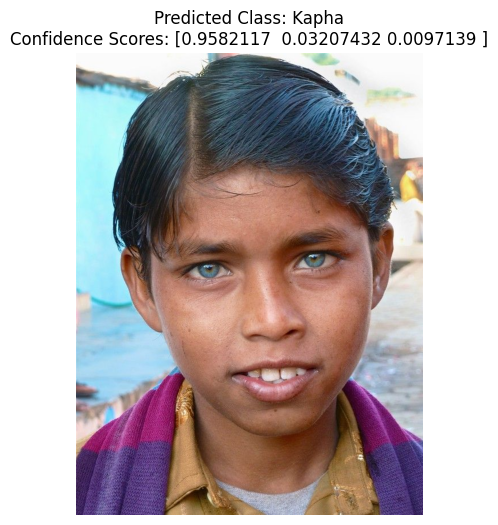

In [2]:
def predict_and_display_image_224(image_path, model):
    """
    Predict the class of a single image and display it.
    Image is resized to 224x224 before prediction.
    
    Parameters:
        image_path (str): Path to the image to predict.
        model (tensorflow.keras.Model): The trained model.
    
    Returns:
        None
    """
    # Load the image
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR (OpenCV) to RGB (Matplotlib)
    
    # Resize the image to 224x224
    img_resized = cv2.resize(img, (224, 224))
    
    # Normalize the image (scale pixel values to [0, 1])
    img_resized = img_resized / 255.0
    
    # Ensure the image has 3 channels (for RGB), repeat if grayscale
    if img_resized.shape[-1] == 1:  # If the image is grayscale
        img_resized = np.repeat(img_resized, 3, axis=-1)
    
    # Add an extra dimension for the batch size (1 image in this case)
    img_input = np.expand_dims(img_resized, axis=0)
    
    # Predict with the model
    predictions = model.predict(img_input)
    
    # Get the class with the highest probability
    predicted_class = np.argmax(predictions, axis=1)
    
    # Map the predicted class to its label
    class_labels = ['Kapha', 'Pittha', 'Vata']
    predicted_label = class_labels[predicted_class[0]]
    
    # Display the image and prediction
    plt.figure(figsize=(6, 6))
    plt.imshow(img_rgb)
    plt.title(f"Predicted Class: {predicted_label}\nConfidence Scores: {predictions[0]}")
    plt.axis('off')
    plt.show()

# Example usage:
image_path =  "C:/Users/kaush/Downloads/f376a5fca76fc505efa982ec34485be0.jpg"  # Replace with the actual path to your image
predict_and_display_image_224(image_path, model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


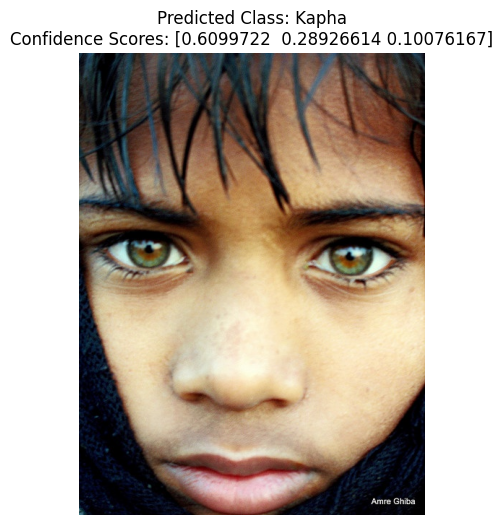

In [4]:
def predict_and_display_image_224(image_path, model):
    """
    Predict the class of a single image and display it.
    Image is resized to 224x224 before prediction.
    
    Parameters:
        image_path (str): Path to the image to predict.
        model (tensorflow.keras.Model): The trained model.
    
    Returns:
        None
    """
    # Load the image
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR (OpenCV) to RGB (Matplotlib)
    
    # Resize the image to 224x224
    img_resized = cv2.resize(img, (224, 224))
    
    # Normalize the image (scale pixel values to [0, 1])
    img_resized = img_resized / 255.0
    
    # Ensure the image has 3 channels (for RGB), repeat if grayscale
    if img_resized.shape[-1] == 1:  # If the image is grayscale
        img_resized = np.repeat(img_resized, 3, axis=-1)
    
    # Add an extra dimension for the batch size (1 image in this case)
    img_input = np.expand_dims(img_resized, axis=0)
    
    # Predict with the model
    predictions = model.predict(img_input)
    
    # Get the class with the highest probability
    predicted_class = np.argmax(predictions, axis=1)
    
    # Map the predicted class to its label
    class_labels = ['Kapha', 'Pittha', 'Vata']
    predicted_label = class_labels[predicted_class[0]]
    
    # Display the image and prediction
    plt.figure(figsize=(6, 6))
    plt.imshow(img_rgb)
    plt.title(f"Predicted Class: {predicted_label}\nConfidence Scores: {predictions[0]}")
    plt.axis('off')
    plt.show()

# Example usage:
image_path =  "C:/Users/kaush/Downloads/704ec85652631ad89c8b2da69d973db6.jpg" # Replace with the actual path to your image
predict_and_display_image_224(image_path, model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


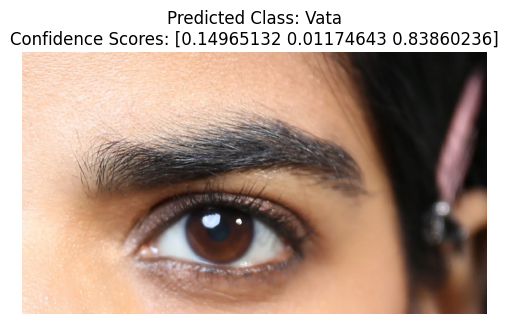

In [5]:
def predict_and_display_image_224(image_path, model):
    """
    Predict the class of a single image and display it.
    Image is resized to 224x224 before prediction.
    
    Parameters:
        image_path (str): Path to the image to predict.
        model (tensorflow.keras.Model): The trained model.
    
    Returns:
        None
    """
    # Load the image
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR (OpenCV) to RGB (Matplotlib)
    
    # Resize the image to 224x224
    img_resized = cv2.resize(img, (224, 224))
    
    # Normalize the image (scale pixel values to [0, 1])
    img_resized = img_resized / 255.0
    
    # Ensure the image has 3 channels (for RGB), repeat if grayscale
    if img_resized.shape[-1] == 1:  # If the image is grayscale
        img_resized = np.repeat(img_resized, 3, axis=-1)
    
    # Add an extra dimension for the batch size (1 image in this case)
    img_input = np.expand_dims(img_resized, axis=0)
    
    # Predict with the model
    predictions = model.predict(img_input)
    
    # Get the class with the highest probability
    predicted_class = np.argmax(predictions, axis=1)
    
    # Map the predicted class to its label
    class_labels = ['Kapha', 'Pittha', 'Vata']
    predicted_label = class_labels[predicted_class[0]]
    
    # Display the image and prediction
    plt.figure(figsize=(6, 6))
    plt.imshow(img_rgb)
    plt.title(f"Predicted Class: {predicted_label}\nConfidence Scores: {predictions[0]}")
    plt.axis('off')
    plt.show()

# Example usage:
image_path = "C:/Users/kaush/Downloads/original.webp" # Replace with the actual path to your image
predict_and_display_image_224(image_path, model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


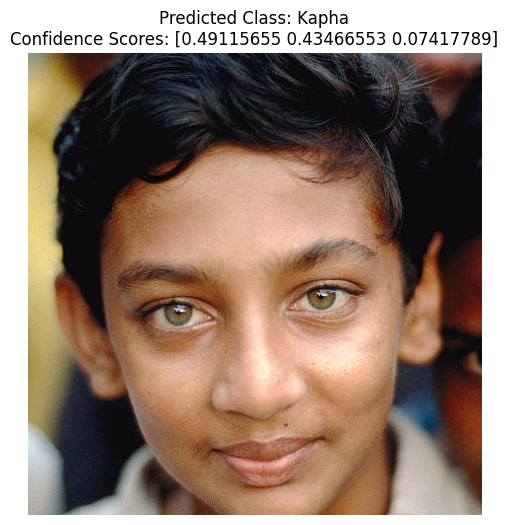

In [6]:
def predict_and_display_image_224(image_path, model):
    """
    Predict the class of a single image and display it.
    Image is resized to 224x224 before prediction.
    
    Parameters:
        image_path (str): Path to the image to predict.
        model (tensorflow.keras.Model): The trained model.
    
    Returns:
        None
    """
    # Load the image
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR (OpenCV) to RGB (Matplotlib)
    
    # Resize the image to 224x224
    img_resized = cv2.resize(img, (224, 224))
    
    # Normalize the image (scale pixel values to [0, 1])
    img_resized = img_resized / 255.0
    
    # Ensure the image has 3 channels (for RGB), repeat if grayscale
    if img_resized.shape[-1] == 1:  # If the image is grayscale
        img_resized = np.repeat(img_resized, 3, axis=-1)
    
    # Add an extra dimension for the batch size (1 image in this case)
    img_input = np.expand_dims(img_resized, axis=0)
    
    # Predict with the model
    predictions = model.predict(img_input)
    
    # Get the class with the highest probability
    predicted_class = np.argmax(predictions, axis=1)
    
    # Map the predicted class to its label
    class_labels = ['Kapha', 'Pittha', 'Vata']
    predicted_label = class_labels[predicted_class[0]]
    
    # Display the image and prediction
    plt.figure(figsize=(6, 6))
    plt.imshow(img_rgb)
    plt.title(f"Predicted Class: {predicted_label}\nConfidence Scores: {predictions[0]}")
    plt.axis('off')
    plt.show()

# Example usage:
image_path = "C:/Users/kaush/Downloads/boy-with-green-eyes-india-wernher-krutein.jpg"# Replace with the actual path to your image
predict_and_display_image_224(image_path, model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


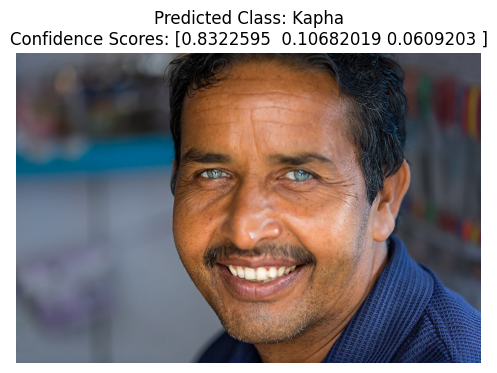

In [8]:
def predict_and_display_image_224(image_path, model):
    """
    Predict the class of a single image and display it.
    Image is resized to 224x224 before prediction.
    
    Parameters:
        image_path (str): Path to the image to predict.
        model (tensorflow.keras.Model): The trained model.
    
    Returns:
        None
    """
    # Load the image
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR (OpenCV) to RGB (Matplotlib)
    
    # Resize the image to 224x224
    img_resized = cv2.resize(img, (224, 224))
    
    # Normalize the image (scale pixel values to [0, 1])
    img_resized = img_resized / 255.0
    
    # Ensure the image has 3 channels (for RGB), repeat if grayscale
    if img_resized.shape[-1] == 1:  # If the image is grayscale
        img_resized = np.repeat(img_resized, 3, axis=-1)
    
    # Add an extra dimension for the batch size (1 image in this case)
    img_input = np.expand_dims(img_resized, axis=0)
    
    # Predict with the model
    predictions = model.predict(img_input)
    
    # Get the class with the highest probability
    predicted_class = np.argmax(predictions, axis=1)
    
    # Map the predicted class to its label
    class_labels = ['Kapha', 'Pittha', 'Vata']
    predicted_label = class_labels[predicted_class[0]]
    
    # Display the image and prediction
    plt.figure(figsize=(6, 6))
    plt.imshow(img_rgb)
    plt.title(f"Predicted Class: {predicted_label}\nConfidence Scores: {predictions[0]}")
    plt.axis('off')
    plt.show()

# Example usage:
image_path ="C:/Users/kaush/Downloads/tumblr_d640ce287cfc90bca04fb5d7ec656471_b5ed8c6d_1280.jpg"  # Replace with the actual path to your image
predict_and_display_image_224(image_path, model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


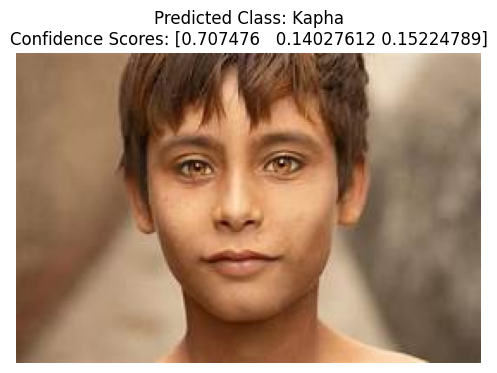

In [2]:
def predict_and_display_image_224(image_path, model):
    """
    Predict the class of a single image and display it.
    Image is resized to 224x224 before prediction.
    
    Parameters:
        image_path (str): Path to the image to predict.
        model (tensorflow.keras.Model): The trained model.
    
    Returns:
        None
    """
    # Load the image
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR (OpenCV) to RGB (Matplotlib)
    
    # Resize the image to 224x224
    img_resized = cv2.resize(img, (224, 224))
    
    # Normalize the image (scale pixel values to [0, 1])
    img_resized = img_resized / 255.0
    
    # Ensure the image has 3 channels (for RGB), repeat if grayscale
    if img_resized.shape[-1] == 1:  # If the image is grayscale
        img_resized = np.repeat(img_resized, 3, axis=-1)
    
    # Add an extra dimension for the batch size (1 image in this case)
    img_input = np.expand_dims(img_resized, axis=0)
    
    # Predict with the model
    predictions = model.predict(img_input)
    
    # Get the class with the highest probability
    predicted_class = np.argmax(predictions, axis=1)
    
    # Map the predicted class to its label
    class_labels = ['Kapha', 'Pittha', 'Vata']
    predicted_label = class_labels[predicted_class[0]]
    
    # Display the image and prediction
    plt.figure(figsize=(6, 6))
    plt.imshow(img_rgb)
    plt.title(f"Predicted Class: {predicted_label}\nConfidence Scores: {predictions[0]}")
    plt.axis('off')
    plt.show()

# Example usage:
image_path ="C:/Users/kaush/Downloads/th (9).jpg"  # Replace with the actual path to your image
predict_and_display_image_224(image_path, model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


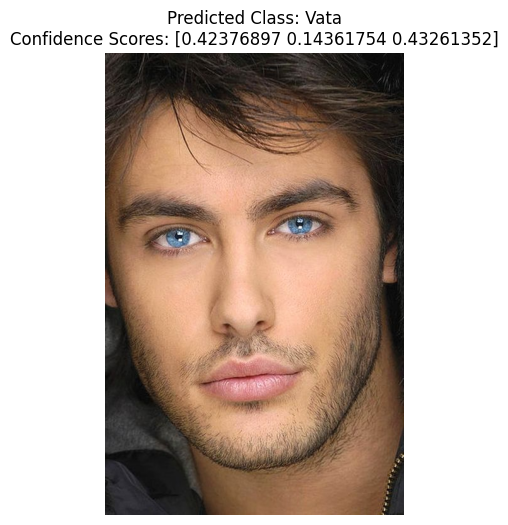

In [4]:
def predict_and_display_image_224(image_path, model):
    """
    Predict the class of a single image and display it.
    Image is resized to 224x224 before prediction.
    
    Parameters:
        image_path (str): Path to the image to predict.
        model (tensorflow.keras.Model): The trained model.
    
    Returns:
        None
    """
    # Load the image
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR (OpenCV) to RGB (Matplotlib)
    
    # Resize the image to 224x224
    img_resized = cv2.resize(img, (224, 224))
    
    # Normalize the image (scale pixel values to [0, 1])
    img_resized = img_resized / 255.0
    
    # Ensure the image has 3 channels (for RGB), repeat if grayscale
    if img_resized.shape[-1] == 1:  # If the image is grayscale
        img_resized = np.repeat(img_resized, 3, axis=-1)
    
    # Add an extra dimension for the batch size (1 image in this case)
    img_input = np.expand_dims(img_resized, axis=0)
    
    # Predict with the model
    predictions = model.predict(img_input)
    
    # Get the class with the highest probability
    predicted_class = np.argmax(predictions, axis=1)
    
    # Map the predicted class to its label
    class_labels = ['Kapha', 'Pittha', 'Vata']
    predicted_label = class_labels[predicted_class[0]]
    
    # Display the image and prediction
    plt.figure(figsize=(6, 6))
    plt.imshow(img_rgb)
    plt.title(f"Predicted Class: {predicted_label}\nConfidence Scores: {predictions[0]}")
    plt.axis('off')
    plt.show()

# Example usage:
image_path ="C:/Users/kaush/Downloads/cc928123633220550bf53a32362f77a5--kostas-martakis-sexy-men.jpg" # Replace with the actual path to your image
predict_and_display_image_224(image_path, model)


In [ ]:
"C:/Users/kaush/Downloads/th (10).jpg" 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


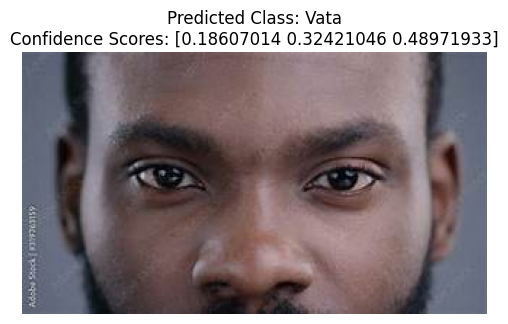

In [5]:
def predict_and_display_image_224(image_path, model):
    """
    Predict the class of a single image and display it.
    Image is resized to 224x224 before prediction.
    
    Parameters:
        image_path (str): Path to the image to predict.
        model (tensorflow.keras.Model): The trained model.
    
    Returns:
        None
    """
    # Load the image
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR (OpenCV) to RGB (Matplotlib)
    
    # Resize the image to 224x224
    img_resized = cv2.resize(img, (224, 224))
    
    # Normalize the image (scale pixel values to [0, 1])
    img_resized = img_resized / 255.0
    
    # Ensure the image has 3 channels (for RGB), repeat if grayscale
    if img_resized.shape[-1] == 1:  # If the image is grayscale
        img_resized = np.repeat(img_resized, 3, axis=-1)
    
    # Add an extra dimension for the batch size (1 image in this case)
    img_input = np.expand_dims(img_resized, axis=0)
    
    # Predict with the model
    predictions = model.predict(img_input)
    
    # Get the class with the highest probability
    predicted_class = np.argmax(predictions, axis=1)
    
    # Map the predicted class to its label
    class_labels = ['Kapha', 'Pittha', 'Vata']
    predicted_label = class_labels[predicted_class[0]]
    
    # Display the image and prediction
    plt.figure(figsize=(6, 6))
    plt.imshow(img_rgb)
    plt.title(f"Predicted Class: {predicted_label}\nConfidence Scores: {predictions[0]}")
    plt.axis('off')
    plt.show()

# Example usage:
image_path ="C:/Users/kaush/Downloads/th (10).jpg"  # Replace with the actual path to your image
predict_and_display_image_224(image_path, model)
